<a href="https://colab.research.google.com/github/A-Arhami/English-German-Translator/blob/main/ENG_to_GER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural translation model

In this notebook, a neural network have been implemented that translates from English to German.
![Flags overview image](data/germany_uk_flags.png)

For the capstone project, I'm using a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, I will restrict to our dataset to 20,000 pairs.





In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split


In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/DIGI/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture I have developed in this project.

![Model Schematic](data/neural_translation_model.png)

Key:
![Model key](data/neural_translation_model_key.png)

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Creating separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided above.
* Adding a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
*  tokenizing the German sentences
* Padding the end of the tokenized German sequences with zeros, and batching the complete set of sequences into one numpy array.

In [ ]:
X=[]
Y=[]
for x in data_examples:
    x=x.split('\t')
    X.append(preprocess_sentence(x[0]))
    Y.append("<start>"+" "+preprocess_sentence(x[1])+" "+"<end>")

    

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None, 
                                                  filters=[])
tokenizer.fit_on_texts(Y)
Y_seq= tokenizer.texts_to_sequences(Y)

In [ ]:
for i in np.random.rand(5)*NUM_EXAMPLES:
    print (X[int(i)],Y[int(i)],"\n",Y_seq[int(i)])

pick it up . <start> hebe es auf . <end> 
 [1, 1819, 10, 29, 3, 2]
you're not alone . <start> du bist nicht allein . <end> 
 [1, 13, 32, 12, 139, 3, 2]
what gives ? <start> was ist los ? <end> 
 [1, 38, 6, 207, 7, 2]
can you show me ? <start> kannst du es mir zeigen ? <end> 
 [1, 109, 13, 10, 21, 709, 7, 2]
why is this ? <start> woran liegt das ? <end> 
 [1, 3383, 353, 11, 7, 2]


In [ ]:
Y_seq_padded=tf.keras.preprocessing.sequence.pad_sequences(Y_seq,20,padding='post')

## 2. Prepare the data with tf.data.Dataset objects

#### Load the embedding layer
As part of the dataset preproceessing for this project, I will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1. 


In [ ]:
# Load embedding module from Tensorflow Hub
embedding_layer = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")

In [ ]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(X,Y_seq_padded,train_size=0.8 )
def list_to_dataset(x,y):
    return tf.data.Dataset.from_tensor_slices((x,y))
train_data=list_to_dataset(x_train,y_train)
test_data=list_to_dataset(x_test,y_test)

In [ ]:
def map_split(dataset):


    def map_func(x, y):

        x = tf.strings.split(x)

        return (x,y)
    mapped_dataset = dataset.map(map_func)
    return mapped_dataset    

train_data=map_split(train_data)
test_data=map_split(test_data)

def map_func1(x, y):

    x = embedding_layer(x)

    return (x,y)

train_data = train_data.map(map_func1)
test_data = test_data.map(map_func1)


train_data = train_data.filter(lambda x, y : len(x) < 14) 
test_data = test_data.filter(lambda x, y : len(x) < 14) 


def map_13(x, y): 

    paddings = tf.constant([[13, 0,], [0, 0]]) 

    new_x = tf.pad(x, paddings) 

    return (new_x[-13:,:], y) 

train_data = train_data.map(map_13) 
test_data = test_data.map(map_13)

In [ ]:
train_data=train_data.batch(16)
test_data=test_data.batch(16)

train_data.element_spec , test_data.element_spec

((TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 20), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 20), dtype=tf.int32, name=None)))

In [ ]:
for feature_batch, label_batch in train_data.take(1):
    x_t = feature_batch
    y_t = label_batch

In [ ]:
print ('ENglish data example Shape in training set {}, GErman data example in validation set {}'.format(x_t.shape,y_t.shape))
for feature_batch, label_batch in train_data.take(1):
    print (label_batch)


ENglish data example Shape in training set (16, 13, 128), GErman data example in validation set (16, 20)
tf.Tensor(
[[   1    4   18   40  368  641    9    2    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   1  393    5   65   75    9    2    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   1    8   35   31  116    3    2    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   1    5  136    3    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   1    4 1043   22   29    5    3    2    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   1  216    8   10    3    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   1   26 1621    6  187    3    2    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   1   70  893   21  211  366    9    2    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   1   13   32   62  138    3    2    0   

## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

![Encoder schematic](data/neural_translation_model_encoder.png)

In [ ]:
class custom_layer(tf.keras.layers.Layer):

    def __init__(self, embedding_dim=128, **kwargs):
        super(custom_layer, self).__init__(**kwargs)
        self.end_token_E = tf.Variable(initial_value=tf.random.uniform(shape=(embedding_dim,)), trainable=True)

    def call(self, inputs):
        end_token = tf.tile(tf.reshape(self.end_token_E, shape=(1, 1, self.end_token_E.shape[0])), [tf.shape(inputs)[0],1,1])
        return tf.keras.layers.concatenate([inputs, end_token], axis=1)

In [ ]:
for feature_batch, label_batch in train_data.take(1):
    x_t = custom_layer()(feature_batch)
    print ("befor:", feature_batch.shape,"after:",x_t.shape)

befor: (16, 13, 128) after: (16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above.

In [ ]:
def Encoder():
    inputs = tf.keras.Input((13,128))
    h = custom_layer()(inputs)
    h = tf.keras.layers.Masking(mask_value=0)(h)
    lstm, hidden_state, cell_state = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)(inputs)
    encoder_model = tf.keras.models.Model(inputs=inputs, outputs= [hidden_state, cell_state])
    return encoder_model

In [ ]:
for feature_batch, label_batch in train_data.take(1):
    x_t = feature_batch



In [ ]:
encoder=Encoder()
hidden_state, cell_state = encoder(x_t)
print ('encoder outputs shape:', hidden_state.shape,cell_state.shape)
encoder.summary()

encoder outputs shape: (16, 512) (16, 512)
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 13, 128)]         0         
_________________________________________________________________
lstm_76 (LSTM)               [(None, 13, 512), (None,  1312768   
Total params: 1,312,768
Trainable params: 1,312,768
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

![Decoder schematic](data/neural_translation_model_decoder.png)

In [ ]:
class Decoder(tf.keras.models.Model):
    def __init__(self,max_tokens):
        super(Decoder, self).__init__()
        self.embedding_layer = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=128, mask_zero=True)
        self.lstm_layer = tf.keras.layers.LSTM(512, return_state=True, return_sequences=True)
        self.dense_layer = tf.keras.layers.Dense(units=max_tokens+1)
    def call(self,inputer,hidden_layer=None,cell_layer=None):
        x=self.embedding_layer(inputer)
        x, h, c = self.lstm_layer(x, initial_state=[hidden_layer, cell_layer])
        x=self.dense_layer(x)
        return x,h,c

In [ ]:
for feature_batch, label_batch in train_data.take(1):
    x_t = feature_batch
    y_t = label_batch
max_tokens=len(tokenizer.index_word)


In [ ]:
hidden_state, cell_state = Encoder()(x_t)
decoder=Decoder(max_tokens)
output, decoder_hs, decoder_cs= decoder(y_t,hidden_state,cell_state)
print("output shape:",output.shape,"\n","hidden shape:",decoder_hs.shape,"\n","cell shape:",decoder_cs.shape)
decoder.summary()

output shape: (16, 20, 5744) 
 hidden shape: (16, 512) 
 cell shape: (16, 512)
Model: "decoder_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     multiple                  735232    
_________________________________________________________________
lstm_80 (LSTM)               multiple                  1312768   
_________________________________________________________________
dense_47 (Dense)             multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop


In [ ]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)
losser = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
encoder=Encoder()
decoder=Decoder(5743)
@tf.function
def loss_fn(encoder,decoder,en_input, gr_input, gr_output, loss):
    with tf.GradientTape() as tape:
        hidden_s, cell_s = encoder(en_input)
        output, hidden_s, cell_s = decoder(gr_input, hidden_s,cell_s)
        loss_value = loss(gr_output, output)
        return loss_value, tape.gradient(loss_value, encoder.trainable_variables+decoder.trainable_variables)
def fit_german_shape(gr):
    input_data = gr[:,:-1]
    output_data = gr[:,1:]
    return input_data,output_data
def training(train, val,optimizer, loss,epochs=5):
    val_loss=[]
    tr_loss=[]

    for epoch in range(epochs):
        batch_num=0
        batch_num2=0
        epoch_loss=0
        epoch_loss2=0
        print ("epoch number:",epoch+1)
        for english,germany in train:
            gr_in,gr_out=fit_german_shape(germany)
            loss1, grad= loss_fn(encoder,decoder,english, gr_in, gr_out, loss)
            optimizer.apply_gradients(zip(grad,encoder.trainable_variables + decoder.trainable_variables))
            epoch_loss=epoch_loss+loss1
            batch_num=batch_num+1
            if batch_num%100==0 : print (batch_num,"/",1000," loss: ",loss1)
        avg_loss=epoch_loss/batch_num
        print("In this train epoch, the training loss Tensor is: "+str(avg_loss))
        for english2,germany2 in val:
            gr_in2,gr_out2=fit_german_shape(germany2)
            #hidden_state,cell_state=model(en)
            #pred,temp1,temp2=decoder(gr_in2,hidden_state,cell_state)
            loss2, temp3 = loss_fn(encoder,decoder,english2, gr_in2, gr_out2,loss)
            epoch_loss2=epoch_loss2+loss2
            batch_num2=batch_num2+1
            if batch_num2%100==0 : print (batch_num2,"/",250," loss: ",loss2)
        avg_loss2=epoch_loss2/batch_num2
        print("In this test epoch, the val-loss Tensor is: "+str(avg_loss2))
        val_loss.append(avg_loss2)
        tr_loss.append(avg_loss)
    return (tr_loss,val_loss)


In [ ]:

history =training(train_data,test_data,optimizer,losser,5)

epoch number: 1
100 / 1000  loss:  tf.Tensor(1.4396588, shape=(), dtype=float32)
200 / 1000  loss:  tf.Tensor(1.1045972, shape=(), dtype=float32)
300 / 1000  loss:  tf.Tensor(1.2860949, shape=(), dtype=float32)
400 / 1000  loss:  tf.Tensor(1.0985256, shape=(), dtype=float32)
500 / 1000  loss:  tf.Tensor(1.2864181, shape=(), dtype=float32)
600 / 1000  loss:  tf.Tensor(1.1528745, shape=(), dtype=float32)
700 / 1000  loss:  tf.Tensor(1.0890355, shape=(), dtype=float32)
800 / 1000  loss:  tf.Tensor(0.9633227, shape=(), dtype=float32)
900 / 1000  loss:  tf.Tensor(1.0881802, shape=(), dtype=float32)
1000 / 1000  loss:  tf.Tensor(1.0377702, shape=(), dtype=float32)
In this train epoch, the training loss Tensor is: tf.Tensor(1.2677264, shape=(), dtype=float32)
100 / 250  loss:  tf.Tensor(1.0909494, shape=(), dtype=float32)
200 / 250  loss:  tf.Tensor(1.1757421, shape=(), dtype=float32)
In this test epoch, the val-loss Tensor is: tf.Tensor(1.0694054, shape=(), dtype=float32)
epoch number: 2
100

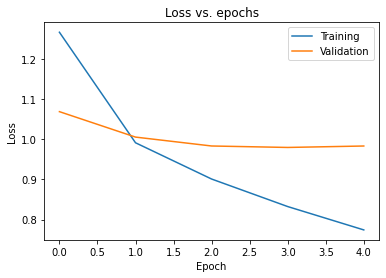

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history[0])
plt.plot(history[1])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 